# BioGPT-PubMedQA-Prefix-Tuning
### The objective is to fine-tune BioGPT for enhanced performance in addressing medical inquiries

## Install libraries used

In [ ]:
!pip install peft transformers datasets torch-xla sacremoses seaborn accelerate

## Import libraries used

In [ ]:
import torch
import torch.nn.functional as F
import torch_xla
import torch_xla.core.xla_model as xm
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from enum import Enum
from datasets import load_dataset, DatasetDict, Dataset
from transformers import BioGptTokenizer, set_seed,get_scheduler, get_linear_schedule_with_warmup, BioGptForCausalLM, default_data_collator, TrainingArguments
from peft import get_peft_config, get_peft_model, PrefixTuningConfig, TaskType, PeftType, AutoPeftModelForCausalLM, LoraConfig, prepare_model_for_int8_training
from tqdm import tqdm
from accelerate import Accelerator
import random, os, seaborn as sns, matplotlib.pyplot as plt, pandas as pd

# PubMedQA Dataset
PubMedQA (Closed-domain question answering given PubMed abstract) dataset contains questions on biomedical research that cover a wide range of biomedical topics, including diseases, treatments, genes, proteins, and more. PubMedQA is one of the MultiMedQA datasets (A benchmark for medical question answering). PubMedQA consists of 1k expert labeled, 61.2k unlabeled, and 211.3k artificially generated QA instances with yes/no/maybe multiple-choice answers and long answers given a question together with a PubMed abstract as context
<div  style="text-align:center;">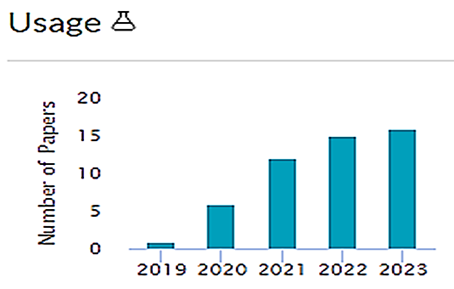</div>

## Load Dataset

In [3]:
dataset_name = "reginaboateng/cleaned_pubmedqa"
pubmed_qa = load_dataset("pubmed_qa", "pqa_artificial")

Generating train split: 100%|██████████| 211269/211269 [00:01<00:00, 116349.04 examples/s]


## Data Preparation for QA Model

In [4]:
data = []
for row in pubmed_qa['train']:
    question = row['question']
    answer = row['long_answer']
    data.append({'Question': question, 'Answer': answer})

train = data[:50]
random.shuffle(train)
train_mapping = {key: [d[key] for d in train] for key in train[0]}
train_dataset = Dataset.from_dict(train_mapping)

validation = data[50:60]
random.shuffle(validation)
val_mapping = {key: [d[key] for d in validation] for key in validation[0]}
val_dataset = Dataset.from_dict(val_mapping)

dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['Question', 'Answer'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['Question', 'Answer'],
        num_rows: 10
    })
})

## Training Data Sample

In [5]:
train_subset = dataset["train"].select(range(5))
for i in range(5):
    print('Question: ' ,train_subset["Question"][i])
    print('Answer: ',train_subset["Answer"][i])
    print()

Question:  Is delayed duodenal stump blow-out following total gastrectomy for cancer : Heightened awareness for the continued presence of the surgical past in the present the key to a successful duodenal stump disruption management . A case report?
Answer:  Several strategies have been proposed for the successful management post-gastrectomy duodenal stump disruption however; its treatment planning is absolutely determined by the presence or not of generalized peritonitis and hemodynamic instability with hostile abdomen. In such scenario, urgent reoperation is mandatory and the damage control principle should govern the operative treatment.

Question:  Does metabolic control analysis of the Trypanosoma cruzi peroxide detoxification pathway identify tryparedoxin as a suitable drug target?
Answer:  These quantitative kinetic and metabolic analyses pointed out to TXN as a convenient drug target due to its low catalytic efficiency, high control on the flux of peroxide detoxification and rol

## Distribution of Sentence Lengths

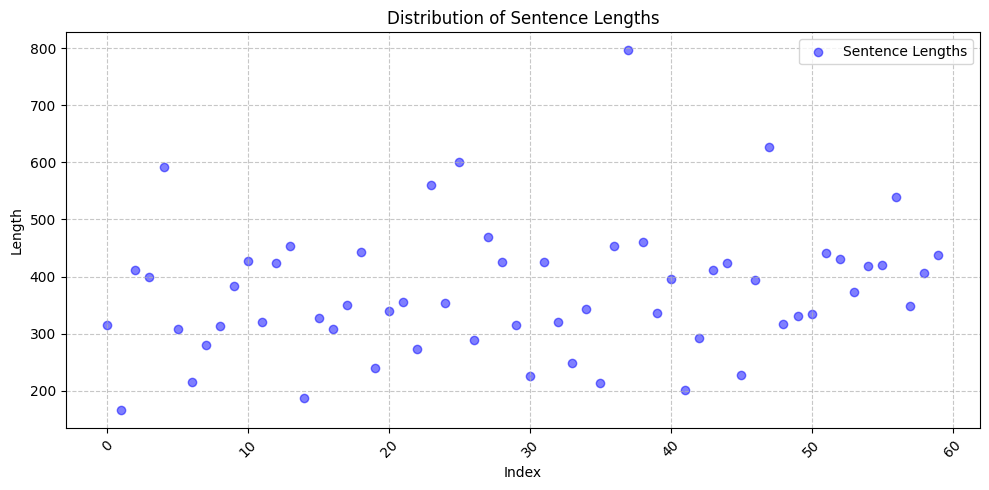

In [6]:
# Calculate lengths of tokenized sentences
lengths_list = []

# Process training data
for data in dataset['train']:
    length = len(data['Question'] + data['Answer'])
    lengths_list.append(length)

# Process validation data
for data in dataset['validation']:
    length = len(data['Question'] + data['Answer'])
    lengths_list.append(length)

# Create DataFrame
lengths = pd.DataFrame({'Length': lengths_list})

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(lengths.index, lengths['Length'], alpha=0.5, color='blue', label='Sentence Lengths')
plt.xlabel('Index')
plt.xticks(rotation=45)
plt.ylabel('Length')
plt.title('Distribution of Sentence Lengths')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Prepare Model And Tokenizer

In [6]:
class SpecialTokens(str, Enum):
    question = "<|question|>"
    answer = "<|answer|>"
    medical = "<|medical|>"
    inquiry = "<|inquiry|>"
    pad_token = "<|pad|>"
    end_answer = "<|endanswer|>"
    @classmethod
    def list(cls):
        return [c.value for c in cls]

# BioGPT Tokenizer
- The GPT-2 tokenizer has a clever way to deal with characters that are not in the training corpus, these characters will be converted to the unknown token. That’s one reason why lots of NLP models are very bad at analyzing content with emojis.

- GPT-2 dones’t look at words as being written with Unicode characters, but with bytes. This way the base vocabulary has a small size (256), a huge vocabulary size means a huge embedding matrix at the start of the model, which will cause memory problems.
- Every character you can think of will still be included and not end up being converted to the unknown token. This trick is called byte-level BPE

<div style="text-align: center;">
    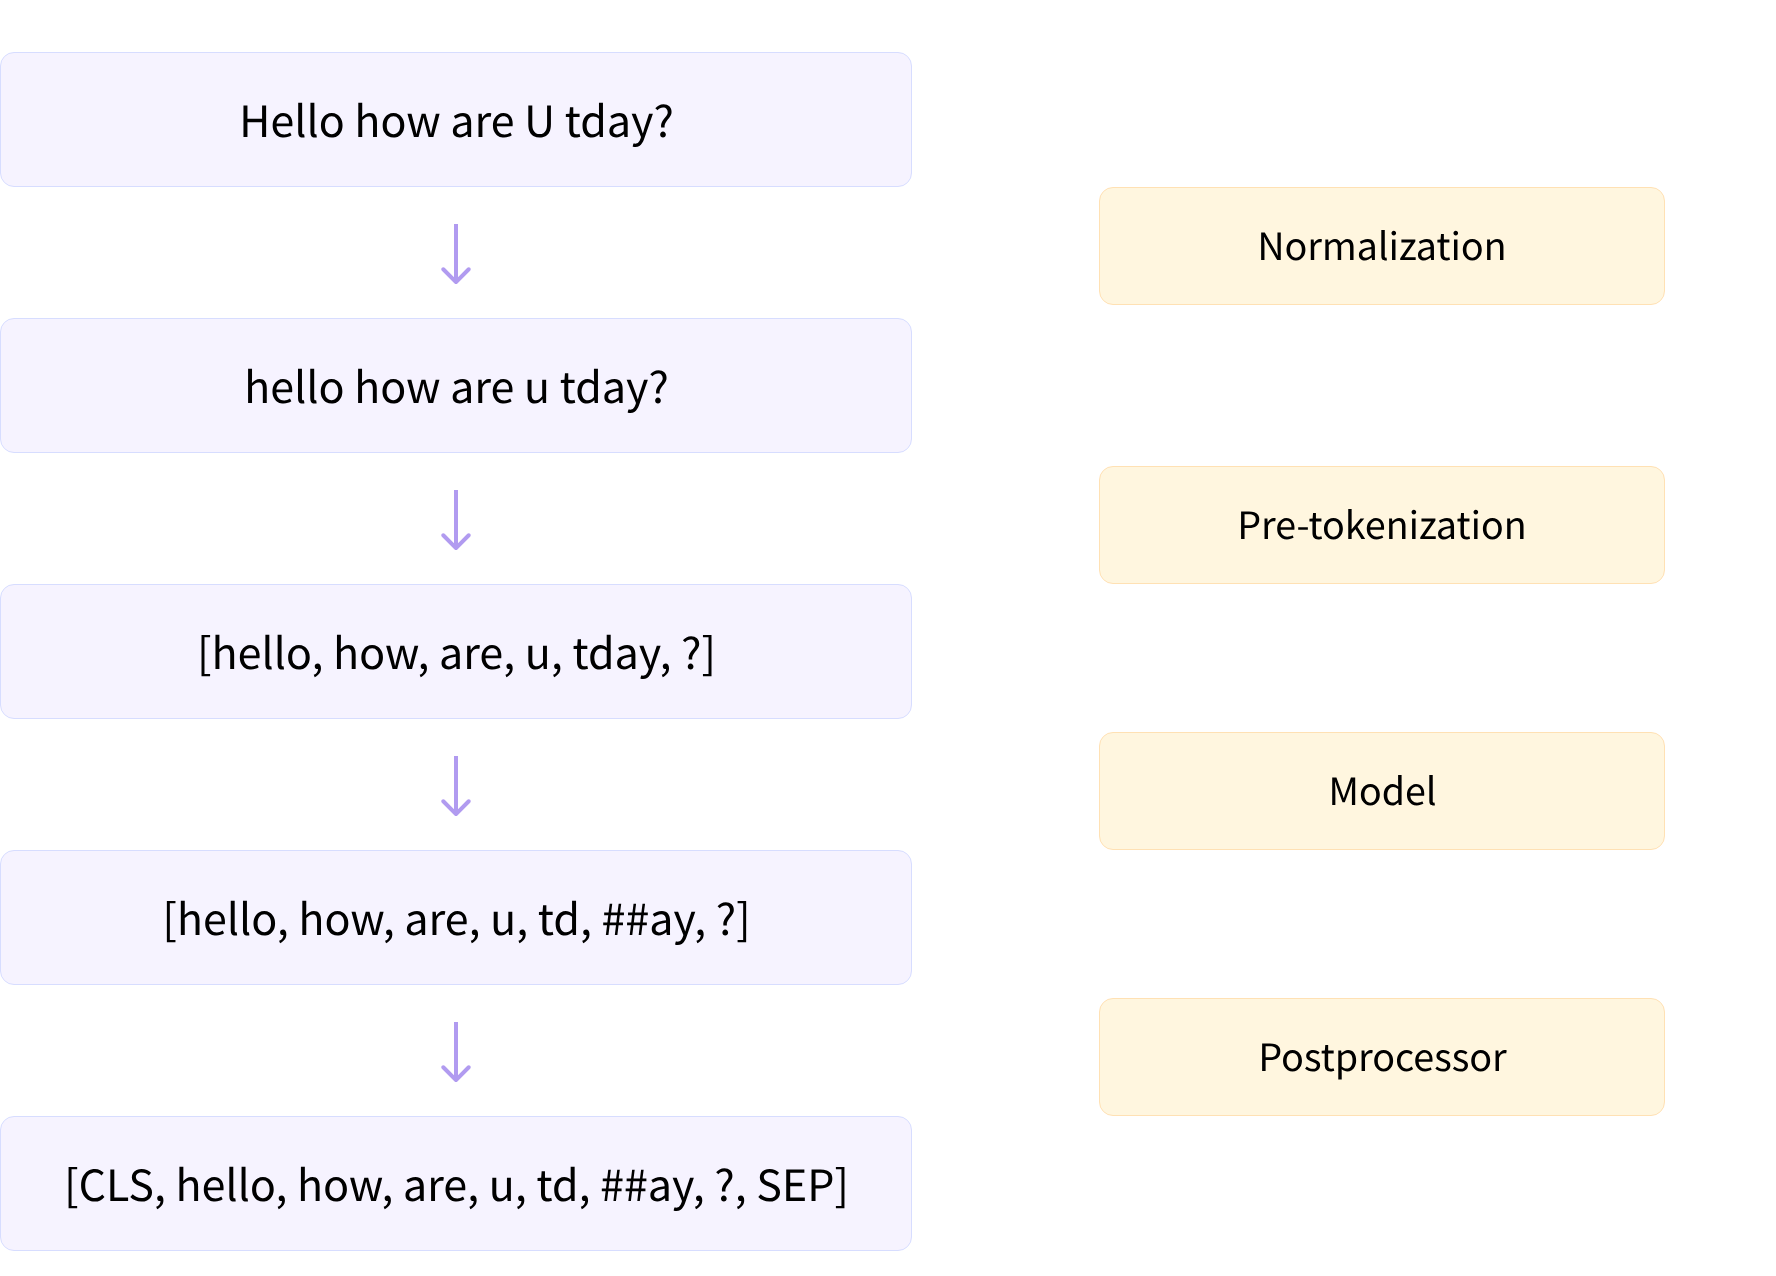
</div>

### Tokenization Steps:

 **1. Normalization**:
      
      * Removing spaces or accents, Unicode normalization, etc.

**2. Pre-tokenization**: 
        
        * Splitting the input into words: GPT-2 splits on whitespace and punctuation and keep spaces and replace them with a Ġ symbol(enabling it to recover the original spaces if we decode the tokens)
        
        * Compute the frequencies of each word
        
        * Create dictionary of words and the frequency

**3. Running the input through the Byte-Pair Encoding Model**:
        
        * Splitting each words in the dictionary into individual characters and compute the base vocabulary
        
        * Applying the merge rules learned in order on those splits
            * Split each word in vocabulary to characters and compute the frequency of each pair
            * Append pairs with large frequencies into the vocabulary
            * Apply all the merge rules learned to tokenize the text

**4. Post-processing**: 
       
       * Adding the special tokens of the tokenizer
       
       * Generate the attention mask and token type IDs)

## Load Tokenizer

In [7]:
tokenizer_name = "microsoft/BioGPT-Large-PubMedQA"  
tokenizer = BioGptTokenizer.from_pretrained(
    tokenizer_name,
    pad_token=SpecialTokens.pad_token.value,
    bos_token=SpecialTokens.question.value,
    eos_token=SpecialTokens.end_answer.value,
    additional_special_tokens=SpecialTokens.list(),
)

## BioGPT Tokenizer Info.

In [9]:
print("The max model length is {} for this model".format(tokenizer.model_max_length))
print('Is tokenizer fast: ' , tokenizer.is_fast)
print('The vocabulary size of the tokenizer is',  tokenizer.vocab_size)
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))
special_tokens_map = tokenizer.special_tokens_map
print("Special Tokens Map:", special_tokens_map)

The max model length is 1024 for this model
Is tokenizer fast:  False
The vocabulary size of the tokenizer is 57726
The beginning of sequence token <|question|> token has the id 57726
The end of sequence token <|endanswer|> has the id 57727
The padding token <|pad|> has the id 57728
Special Tokens Map: {'bos_token': '<|question|>', 'eos_token': '<|endanswer|>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<|pad|>', 'additional_special_tokens': ['<|question|>', '<|answer|>', '<|medical|>', '<|inquiry|>', '<|pad|>', '<|endanswer|>']}


# BioGPT Model

### The Pre-trained Model is BioGPT
BioGPT, which was announced by Microsoft, used to analyze biomedical research with the aim of answering biomedical questions and can be especially relevant in helping researchers gain new insights. BioGPT is a type of generative Large Language Model (LLM), which is trained on millions of biomedical research articles that have already been published. This essentially means that BioGPT can use this information to perform other tasks like answering questions, extracting relevant data, and generating text relevant to biomedical.
The researchers used GPT-2 XL as the primary model and trained it on 15 million PubMed abstracts before using it in the real world. GPT-2 XL is a Transformer decoder that has 48 layers, 1600 hidden sizes, and 25 attention heads resulting in 1.5B parameters in total.

<div style="text-align: center;">
    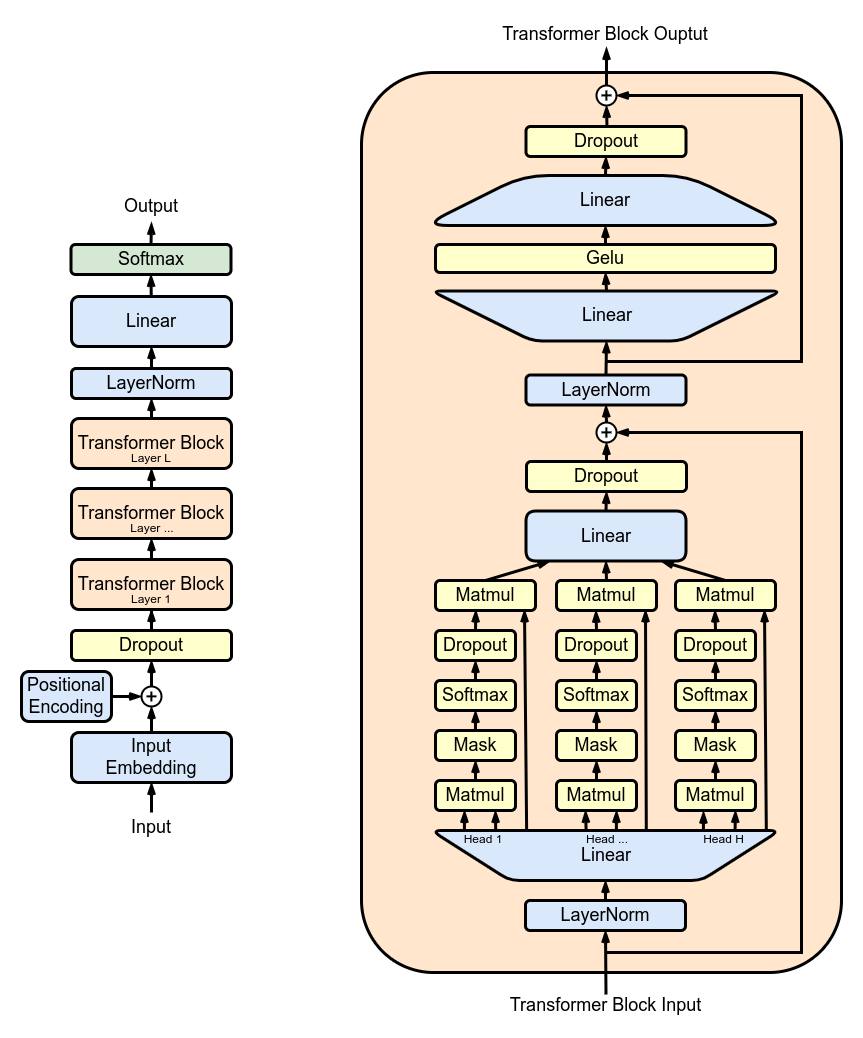
</div>


## Load Pretrained Model

In [8]:
model_name = "microsoft/BioGPT-Large-PubMedQA"
model = BioGptForCausalLM.from_pretrained(model_name,low_cpu_mem_usage=True)
model.resize_token_embeddings(len(tokenizer))
device = xm.xla_device()
model = model.to(device)
model

/usr/local/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BioGptForCausalLM(
  (biogpt): BioGptModel(
    (embed_tokens): Embedding(57732, 1600)
    (embed_positions): BioGptLearnedPositionalEmbedding(2050, 1600)
    (layers): ModuleList(
      (0-47): 48 x BioGptDecoderLayer(
        (self_attn): BioGptAttention(
          (k_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (v_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (q_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1600, out_features=6400, bias=True)
        (fc2): Linear(in_features=6400, out_features=1600, bias=True)
        (final_layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affi

## Apply LoRA

In [9]:
config = LoraConfig(
    r=64, lora_alpha=128, lora_dropout=0.0, target_modules=["embed_tokens", "lm_head", "q_proj", "v_proj"]
)
model = get_peft_model(model, config)
print(model.print_trainable_parameters())
print(model)

trainable params: 23,458,048 || all params: 1,687,042,048 || trainable%: 1.3904838962259227
None
PeftModel(
  (base_model): LoraModel(
    (model): BioGptForCausalLM(
      (biogpt): BioGptModel(
        (embed_tokens): lora.Embedding(
          (base_layer): Embedding(57732, 1600)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict()
          (lora_B): ModuleDict()
          (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.xla.FloatTensor of size 64x57732])
          (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.xla.FloatTensor of size 1600x64])
        )
        (embed_positions): BioGptLearnedPositionalEmbedding(2050, 1600)
        (layers): ModuleList(
          (0-47): 48 x BioGptDecoderLayer(
            (self_attn): BioGptAttention(
              (k_proj): Linear(in_features=1600, out_features=1600, bias=True)
              (v_proj): lora.Linear(
             

# Data Preprocessing

In [10]:
def preprocess_function(examples):
    max_length = 1024    
    batch_size = len(examples['Question'])
    
    inputs = ['Question: ' + str(x) for x in examples['Question']]
    targets = ['Answer: ' + str(x) for x in examples['Answer']]
    
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets)
    
    for i in range(batch_size):
        sample_input_ids = [tokenizer.bos_token_id] + model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]

        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])

    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
)
train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]
print(train_dataset)
print(eval_dataset)

Map: 100%|██████████| 10/10 [00:00<00:00, 280.79 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 50
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10
})


## Tokenize one sentence

In [14]:
sentence = dataset['train'][3]['Question'] + dataset['train'][3]['Answer']
print(sentence, '\n')
print('The example length:', len(sentence),'\n')

print('tokens: ', tokenizer.tokenize(sentence),'\n')

tokenized_example = tokenizer(sentence)
print('Tokens type:', type(tokenized_example),'\n')
print('Tokens ids:\n', tokenized_example,'\n')
print('Tokens length:', len(tokenized_example['input_ids']),'\n')

decoded_example = tokenizer.decode(tokenized_example['input_ids'])
print('Converting to original text\n', decoded_example,'\n')

Do immunizations with hepatitis B viral antigens and a TLR7/8 agonist adjuvant induce antigen-specific immune responses in HBV-transgenic mice?Immunization with CL097-conjugated HBV-Ag reversed immune tolerance in HBV-Tg mice and induced antigen-specific immune responses. TLR7/8 agonists appear to be potent adjuvants for the induction of antigen-specific Th1 responses in an immune tolerant state. 

The example length: 399 

tokens:  ['Do</w>', 'immunizations</w>', 'with</w>', 'hepatitis</w>', 'B</w>', 'viral</w>', 'antigens</w>', 'and</w>', 'a</w>', 'TLR7</w>', '/</w>', '8</w>', 'agonist</w>', 'adjuvant</w>', 'induce</w>', 'antigen</w>', '@-@</w>', 'specific</w>', 'immune</w>', 'responses</w>', 'in</w>', 'HBV</w>', '@-@</w>', 'transgenic</w>', 'mice</w>', '?</w>', 'Immunization</w>', 'with</w>', 'CL', '0', '9', '7</w>', '@-@</w>', 'conjugated</w>', 'HBV</w>', '@-@</w>', 'Ag</w>', 'reversed</w>', 'immune</w>', 'tolerance</w>', 'in</w>', 'HBV</w>', '@-@</w>', 'Tg</w>', 'mice</w>', 'and</

## Dataset Length After Tokenization 

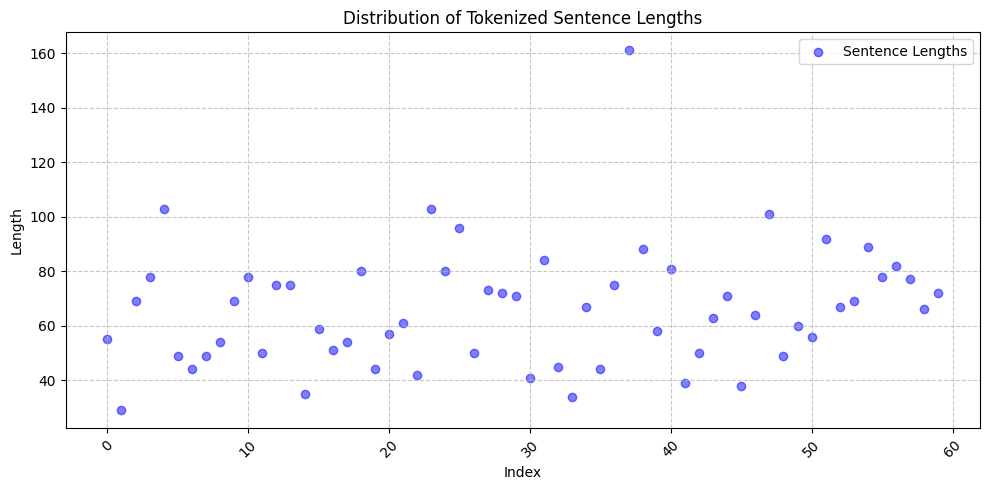

In [15]:
# Calculate lengths of tokenized sentences
lengths_list = []

# Process training data
for data in dataset['train']:
    length = len(tokenizer.encode(data['Question'] + data['Answer']))
    lengths_list.append(length)

# Process validation data
for data in dataset['validation']:
    length = len(tokenizer.encode(data['Question'] + data['Answer']))
    lengths_list.append(length)

# Create DataFrame
tokenized_lengths = pd.DataFrame({'Length': lengths_list})

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(tokenized_lengths.index, tokenized_lengths['Length'], alpha=0.5, color='blue', label='Sentence Lengths')
plt.xlabel('Index')
plt.xticks(rotation=45)
plt.ylabel('Length')
plt.title('Distribution of Tokenized Sentence Lengths')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Data Loading

In [13]:
batch_size=8
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

next(iter(train_dataloader))

{'input_ids': tensor([[57728, 57728, 57728,  ...,  1666,     4, 57727],
         [57728, 57728, 57728,  ...,  9377,     4, 57727],
         [57728, 57728, 57728,  ..., 22515,     4, 57727],
         ...,
         [57728, 57728, 57728,  ...,   451,     4, 57727],
         [57728, 57728, 57728,  ...,    51,     4, 57727],
         [57728, 57728, 57728,  ..., 20716,     4, 57727]]),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'labels': tensor([[ -100,  -100,  -100,  ...,  1666,     4, 57727],
         [ -100,  -100,  -100,  ...,  9377,     4, 57727],
         [ -100,  -100,  -100,  ..., 22515,     4, 57727],
         ...,
         [ -100,  -100,  -100,  ...,   451,     4, 57727],
         [ -100,  -100,  -100,  ...,    51,     4, 57727],
         [ -100,  -100,  -100,  ..., 20716,     4, 577

# Train The Model

## Prefix Tuning - Soft Prompt

### Fine-tuning Process
To adapt BioGPT to answer medical inquiries, Prefix tuning used instead of full model finetuning on a small set of the PubMedQA which effectively used to instruct the model to produce text generations more aligned with the requirements of the medical domain.
#### Soft Prompt in Prefix Tuning
Large Language Models (LLMs) with hundreds of billions of parameters have become computationally expensive and very time-consuming to fine-tune. To address this issue, Lester et al. introduced prompt tuning, a computationally efficient method for adapting LLMs to specific downstream tasks, even with limited data, and a small number of labeled examples (e.g., tens)
Soft prompts in prefix tuning leverage continuous embeddings (virtual tokens) to steer the pre-trained language model by directly appending several additional virtual tokens before the text as the prompts while keeping the remaining LLM parameters frozen. Such continuous embeddings are randomly initialized and learned end-to-end on the downstream tasks to be task specific. we didn’t append the virtual tokens to the very beginning of the source input, but only before the target sequence (between the source and the target). Equipped with the prompt, our final sequence is constructed as [source; prompt; target]

<div style="text-align: center;">
    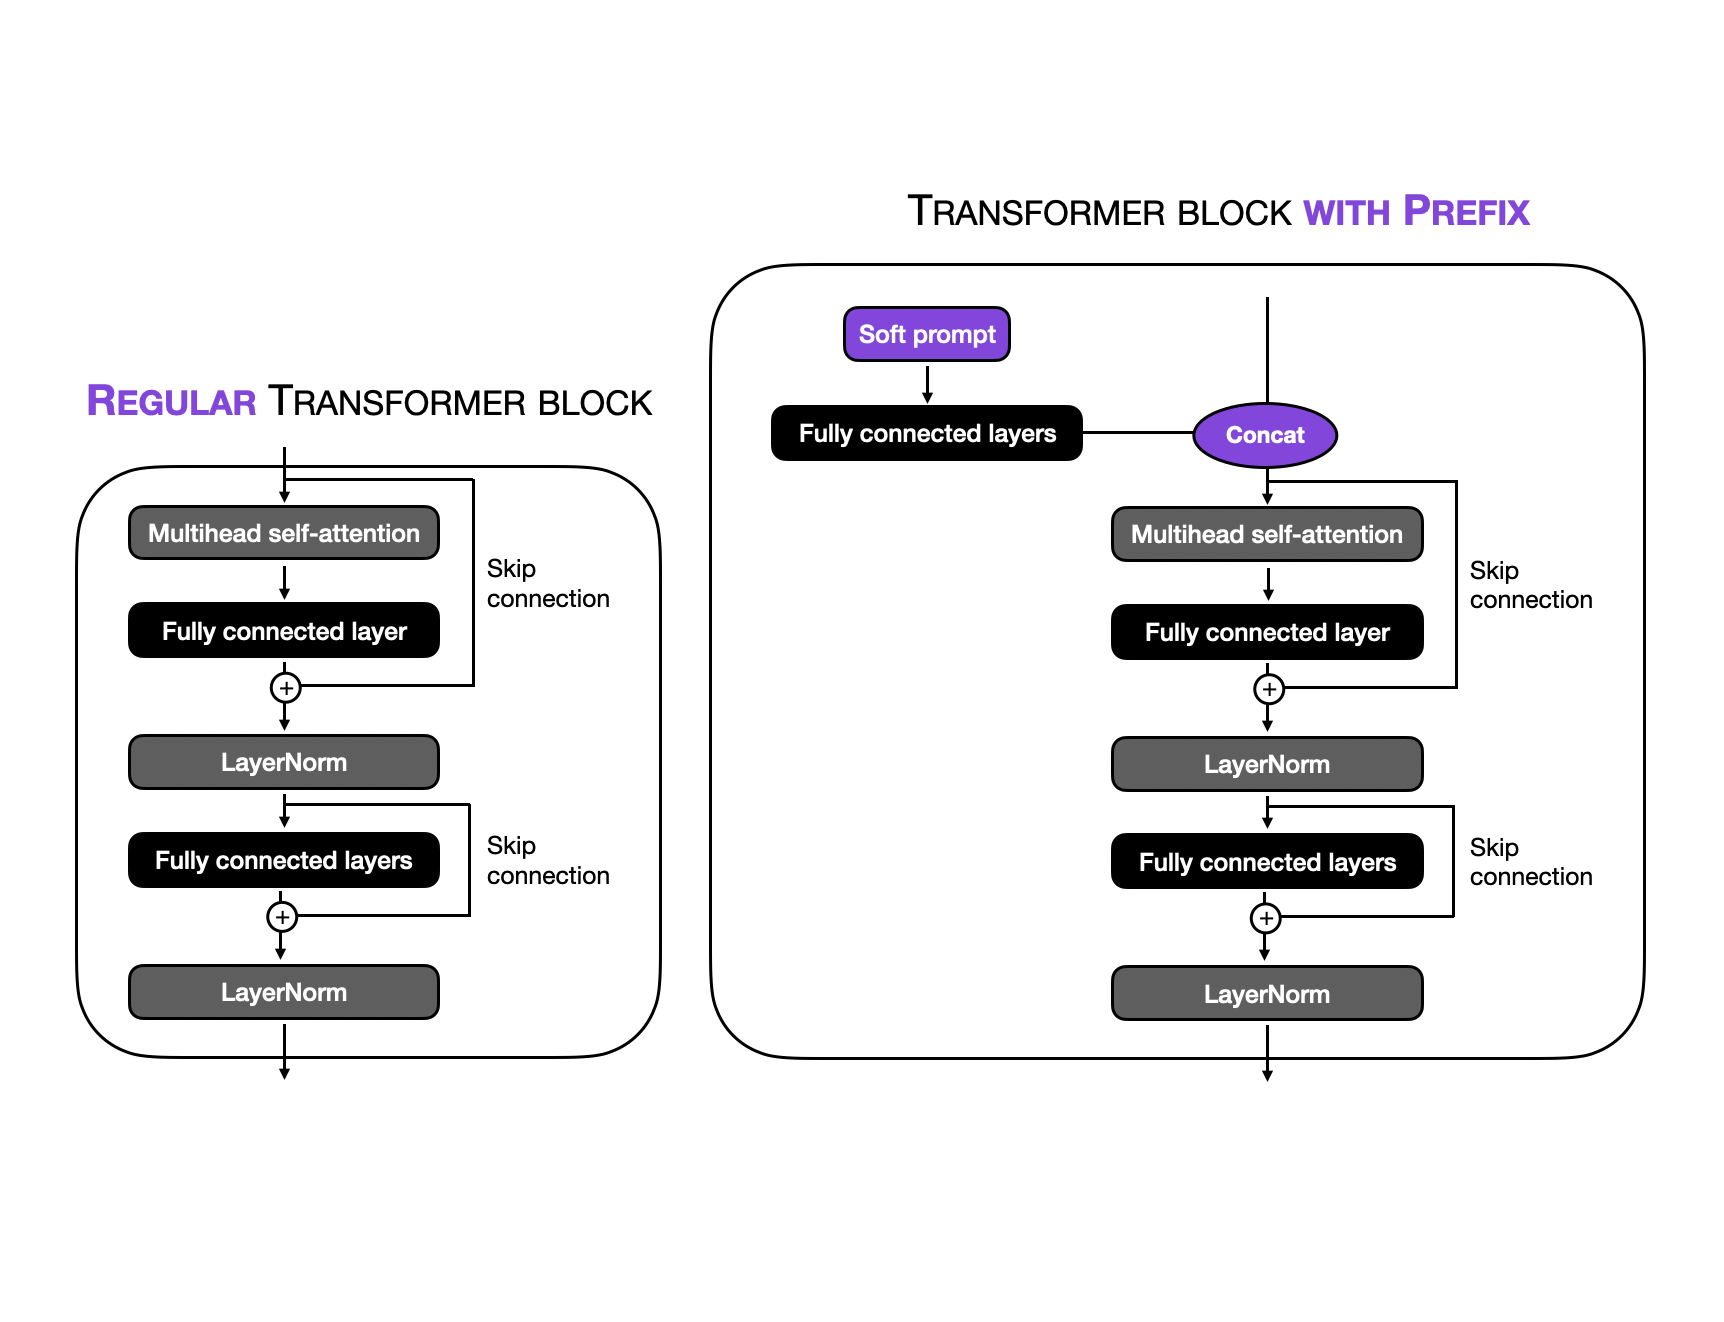
</div>

## PEFT

**PEFT (Parameter-Efficient Fine-Tuning) is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly. PEFT methods only fine-tune a small number of (extra) model parameters - significantly decreasing computational and storage costs - while yielding performance comparable to a fully fine-tuned model. This makes it more accessible to train and store large language models (LLMs) on consumer hardware.**

## LoRA
**LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.**

In [14]:
def evaluate(model, eval_dataloader):
    device = xm.xla_device()
    model = model.to(device)
    
    model.eval()
    
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            input_ids = batch["input_ids"].to("xla")
            labels = batch["labels"].to("xla")
            logits = model(input_ids).logits
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))

            losses.append(loss.item())  
    
    loss_tensor = torch.tensor(losses, device="xla") 
    loss = torch.mean(loss_tensor)  
    perplexity = torch.exp(loss) if torch.isfinite(loss) else float("inf")
    return loss.item(), perplexity.item()

## Intialize Training Parameters

In [22]:
pretrainedModelLoss , pretrainedModelPerplexity = evaluate(model,eval_dataloader)
print("Loss: ",pretrainedModelLoss , " Perplexity: ",pretrainedModelPerplexity)

Loss:  12.375885009765625  Perplexity:  237016.3125


In [24]:
weight_decay = 0.1
lr = 1e-5

optimizer = AdamW(model.parameters(), lr=lr)

accelerator = Accelerator()

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)
gradient_accumulation_steps = 4

In [ ]:
loss_train = []
loss_eval = []

model.train()
for epoch in range(num_train_epochs):
    device = xm.xla_device()
    model = model.to(device)
    
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to('xla')
        labels = batch["labels"].to('xla')
        logits = model(input_ids).logits
        
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss_train.append(loss.item())  
        
        if step % gradient_accumulation_steps == 0:
            accelerator.backward(loss)
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        accelerator.print({
          "step": step+1,
          "train/loss": f"{loss.item():.2f}"}
        )
        
    eval_loss, perplexity = evaluate(model, eval_dataloader)
    loss_eval.append(eval_loss)      
    accelerator.print({
          "epoch": epoch+1,
          "eval/loss": f"{eval_loss:.2f}",
          "eval/perplexity": f"{perplexity:.2f}"}
    )

{'step': 1, 'train/loss': '12.40'}
{'step': 2, 'train/loss': '12.14'}
{'step': 3, 'train/loss': '11.99'}
{'step': 4, 'train/loss': '12.35'}
{'step': 5, 'train/loss': '12.46'}
{'step': 6, 'train/loss': '12.50'}
{'step': 7, 'train/loss': '12.42'}
{'step': 8, 'train/loss': '11.07'}
{'epoch': 1, 'eval/loss': '12.33', 'eval/perplexity': '226804.66'}
{'step': 1, 'train/loss': '12.76'}
{'step': 2, 'train/loss': '12.53'}
{'step': 3, 'train/loss': '12.29'}
{'step': 4, 'train/loss': '12.15'}
{'step': 5, 'train/loss': '12.35'}
{'step': 6, 'train/loss': '12.65'}
{'step': 7, 'train/loss': '12.27'}
{'step': 8, 'train/loss': '11.80'}
{'epoch': 2, 'eval/loss': '12.33', 'eval/perplexity': '226804.66'}
{'step': 1, 'train/loss': '12.78'}
{'step': 2, 'train/loss': '12.44'}
{'step': 3, 'train/loss': '12.23'}
{'step': 4, 'train/loss': '12.19'}


# Model Evaluation - Perplexity And Loss

In [20]:
modelLoss , modelPerplexity = evaluate(model, eval_dataloader)
print("Loss: ",modelLoss , " Perplexity: ",modelPerplexity)

Loss: 9.20885009765625  Perplexity: 1350.9078


# Baselines Comparison

In [25]:
comparison = {
    "BioGPT Large" :[pretrainedModelLoss,pretrainedModelPerplexity], 
    "BioGPT-PubMedQA-Prefix-Tuning" :[modelLoss,modelPerplexity]
}

index_names = ["Loss", "Perplexity"]
data = pd.DataFrame(comparison, index=index_names)
data

,BioGPT Large,BioGPT-PubMedQA-Prefix-Tuning
Loss,12.375885,9.20885
Perplexity,237016.312500,1350.90780


# Assess Overfitting

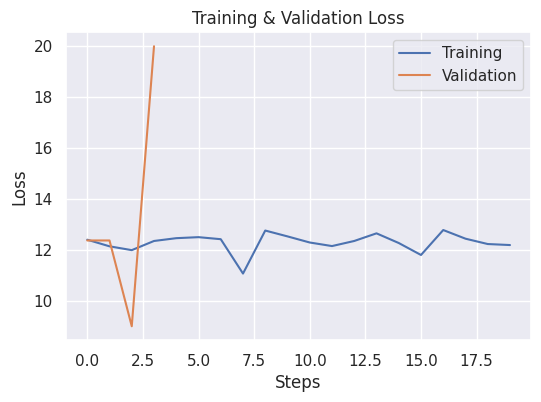

In [34]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
plt.rcParams["figure.figsize"] = (6,4)

# Plot the learning curve.
plt.plot(loss_train, label="Training")
plt.plot(loss_eval, label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Testing

In [38]:
user_input = "what are the symptoms of hypertension?"
print(user_input)

sentence = 'Question: ' + user_input + '. Answer: '

inputs = tokenizer(sentence, return_tensors="pt")
print(inputs)

output = model.generate(**inputs, max_length=200, num_return_sequences=1, no_repeat_ngram_size=2, repetition_penalty=1.5, top_p=0.92, temperature=1.0)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
generated_text

what are the symptoms of hypertension?
{'input_ids': tensor([[    2,  4950, 32691,    52,  1864,    48,     8,   571,     9,  1284,
           752,     4,  2454,  5895,   953,    52]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


'Question: what are the symptoms of hypertension?. Answer: Hypertension is a systemic disease that affects all organs and systems in our body, including cardiovascular system (CVS); however it remains underdiagnosed due to lack awareness among patients as well physicians regarding its clinical manifestations which can be very vague or even absent at presentation leading sometimes for years undiagnosed until complications develop.. The aim of this review article was therefore not only highlighting some common but also uncommon presentations associated with primary arterial hypertension such us headache, visual disturbances like transient ischemic attack / stroke etc … It will hopefully help clinicians who deal daily with hypertensive emergencies recognize these early warning signs so they may institute prompt treatment thereby reducing morbidity & mortality related directly to uncontrolled blood pressure levels especially when left untreated during emergency department visits.Key words:

# Save Model

In [40]:
checkpoint_name = "BioGPT-PubMedQA-Prefix-Tuning-LoRA"
output_dir = '.' + checkpoint_name + '/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('.BioGPT-PubMedQA-Prefix-Tuning-LoRA/tokenizer_config.json',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/special_tokens_map.json',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/vocab.json',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/merges.txt',
 '.BioGPT-PubMedQA-Prefix-Tuning-LoRA/added_tokens.json')